# Kuairec dataset

In [1]:
# Change this line to read from desired file

In [2]:
cd "~/documents/KuaiRec 2.0"

/home/gerardoduran/documents/KuaiRec 2.0


/home/gerardoduran/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [5]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
video_stats = pd.read_csv("./data/item_daily_features.csv")
video_stats.head()

,video_id,date,author_id,video_type,upload_dt,upload_type,visible_status,video_duration,video_width,video_height,...,download_cnt,download_user_num,report_cnt,report_user_num,reduce_similar_cnt,reduce_similar_user_num,collect_cnt,collect_user_num,cancel_collect_cnt,cancel_collect_user_num
0,0,20200705,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,8,8,0,0,3,3,NaN,NaN,NaN,NaN
1,0,20200706,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,2,2,0,0,5,5,NaN,NaN,NaN,NaN
2,0,20200707,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,2,2,0,0,0,0,NaN,NaN,NaN,NaN
3,0,20200708,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,3,3,0,0,3,3,NaN,NaN,NaN,NaN
4,0,20200709,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,...,2,2,2,1,1,1,NaN,NaN,NaN,NaN


In [8]:
target_cols = ["video_id", "date", "like_cnt"]
video_stats[target_cols]

,video_id,date,like_cnt
0,0,20200705,573
1,0,20200706,302
2,0,20200707,205
3,0,20200708,297
4,0,20200709,307
...,...,...,...
343336,10723,20200905,24
343337,10724,20200905,264
343338,10725,20200905,851
343339,10726,20200905,44


In [9]:
cols_merge = ["video_id", "date"]
small_matrix = pd.read_csv("data/small_matrix.csv").dropna()
small_matrix = small_matrix.merge(video_stats[target_cols], on=cols_merge)
small_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,like_cnt
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,4726
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,129431
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311,92689
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388,191275
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,26539


<Axes: xlabel='watch_ratio', ylabel='Count'>

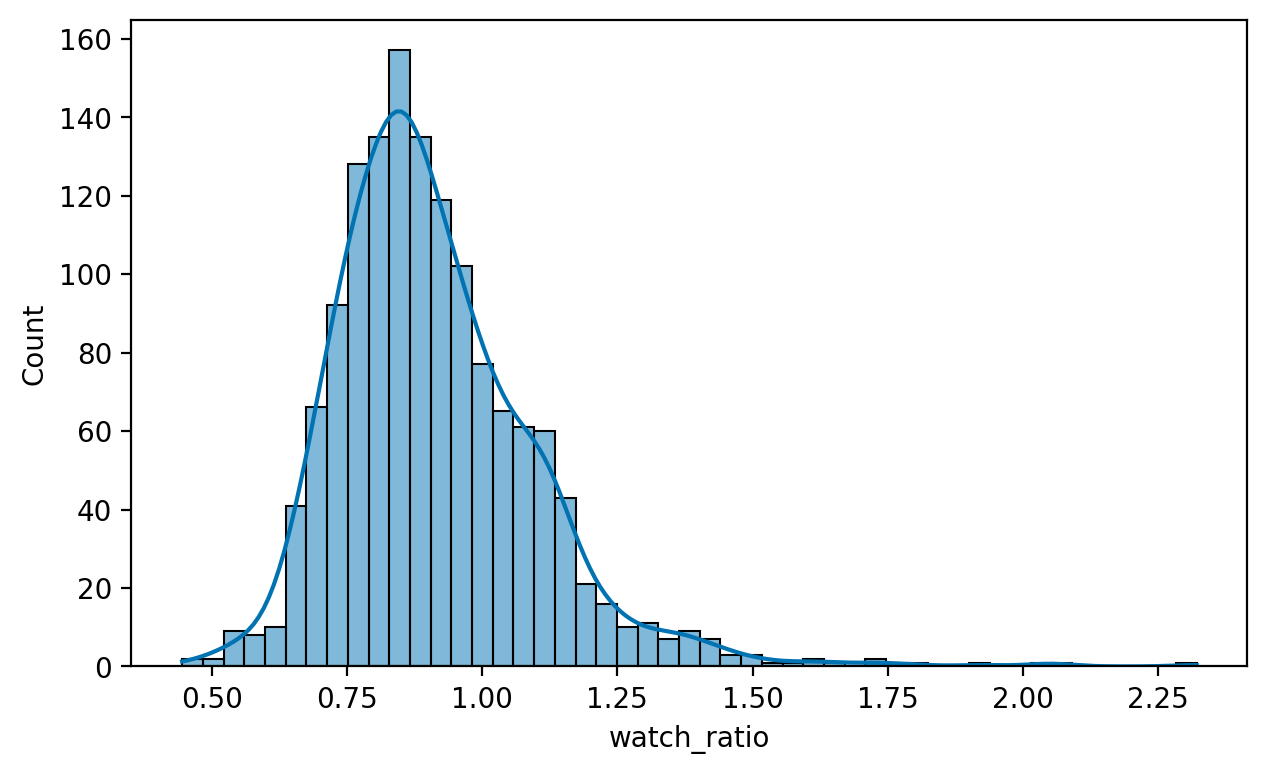

In [10]:
sns.histplot(small_matrix.groupby("user_id")["watch_ratio"].mean(), kde=True)

## Parse dataset

In [11]:
%%time
small_matrix_sub = small_matrix.dropna(subset="date")
small_matrix_sub = small_matrix_sub.assign(time=pd.to_datetime(small_matrix_sub["time"]))

unique_videos = small_matrix_sub["video_id"].unique()

# Encode new id for Embedding layer
id_to_ix_video = {id.item(): i for i, id in enumerate(unique_videos)}
small_matrix_sub = small_matrix_sub.assign(video_id=small_matrix_sub["video_id"].apply(lambda x: id_to_ix_video[x]))

CPU times: user 3.08 s, sys: 156 ms, total: 3.23 s
Wall time: 3.23 s


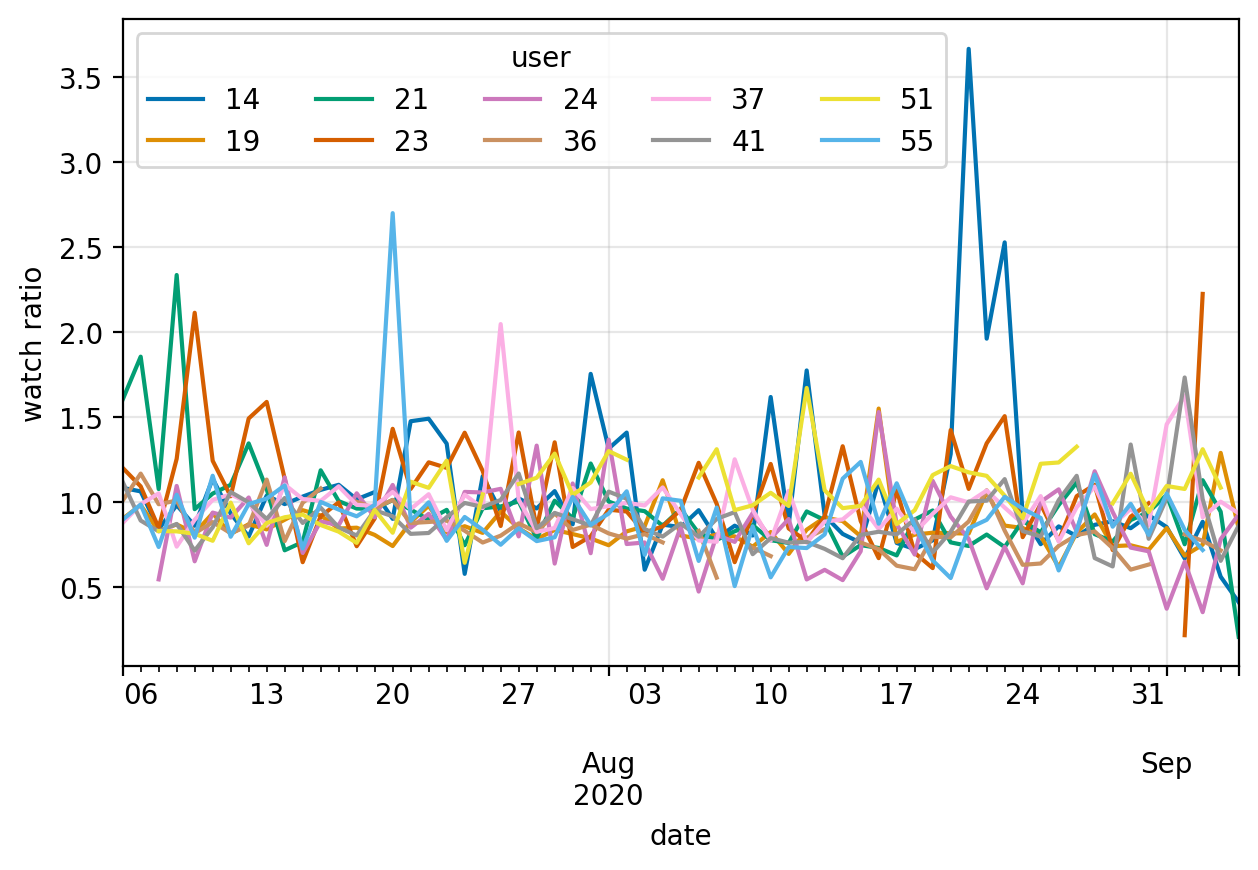

In [12]:
daily_wr = small_matrix_sub.set_index("time").resample("D")["watch_ratio"].mean()

daily_wr = small_matrix_sub.pivot_table(index="date", columns="user_id", values="watch_ratio")
daily_wr.index = pd.to_datetime(daily_wr.index.astype(int).astype(str), yearfirst=format("%Y%m%d"))

daily_wr.iloc[:, :10].plot()
plt.legend(ncol=5, title="user")
plt.ylabel("watch ratio")
plt.grid(alpha=0.3)

## Process dataset

In [30]:
import os
from functools import partial
from multiprocessing import Pool

In [26]:
def parse_batch_users(users, n_arms=5):
    df_batch = []
    for user in users:
        subset = small_matrix_sub.query("user_id == @user")
        n_values = len(subset)
        subset = subset.assign(group=np.arange(n_values) // n_arms)
        
        df_flat = subset.groupby("group").apply(lambda x: x.values.flatten(), include_groups=False).apply(pd.Series)
        df_flat.columns = [f"{col}_{i}" for i in range(n_arms) for col in subset.columns[:-1]]
        df_batch.append(df_flat)
    return df_batch

In [29]:
n_arms = 5
n_cores = os.cpu_count()
users = small_matrix_sub["user_id"].unique()
users_by_batch = np.array_split(users, n_cores)

In [31]:
%%time
poolfn = partial(parse_batch_users, n_arms=n_arms)
with Pool(n_cores) as pool:
    df_all = pool.map(poolfn, users_by_batch)
df_all = [element for batch in df_all for element in batch]
df_all = pd.concat(df_all, axis=0)
df_all.shape

CPU times: user 1.95 s, sys: 5.55 s, total: 7.51 s
Wall time: 10.3 s


(899481, 45)

In [32]:
df_all.head()

,user_id_0,video_id_0,play_duration_0,video_duration_0,time_0,date_0,timestamp_0,watch_ratio_0,like_cnt_0,user_id_1,...,like_cnt_3,user_id_4,video_id_4,play_duration_4,video_duration_4,time_4,date_4,timestamp_4,watch_ratio_4,like_cnt_4
group,,,,,,,,,,,,,,,,,,,,,
0,14,0,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,4726,14.0,...,191275.0,14.0,4.0,4602.0,11000.0,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,26539.0
1,14,5,8607,13267,2020-07-05 05:36:00.773,20200705.0,1.593899e+09,0.648753,3180,14.0,...,594.0,14.0,9.0,8518.0,5217.0,2020-07-05 05:57:26.581,20200705.0,1.593900e+09,1.632739,2336.0
2,14,10,8614,6334,2020-07-05 06:14:51.500,20200705.0,1.593901e+09,1.359962,1131,14.0,...,22378.0,14.0,14.0,8642.0,6067.0,2020-07-05 06:51:24.362,20200705.0,1.593903e+09,1.424427,489.0
3,14,15,8710,7074,2020-07-05 06:52:26.169,20200705.0,1.593903e+09,1.231269,520,14.0,...,4029.0,14.0,19.0,8543.0,5734.0,2020-07-05 08:18:08.954,20200705.0,1.593908e+09,1.489885,3104.0
4,14,20,4588,6933,2020-07-05 08:22:10.226,20200705.0,1.593909e+09,0.661763,30347,14.0,...,2492.0,14.0,24.0,4453.0,6850.0,2020-07-05 09:08:13.209,20200705.0,1.593911e+09,0.650073,42.0


In [33]:
df_all.to_pickle(f"./data/arms_{n_arms:02}_raw.pkl")

## A simple bandit

In [34]:
df_all = pd.read_pickle("./data/arms_05_raw.pkl").dropna()

In [35]:
import jax
import chex
import jax.numpy as jnp

In [36]:
@chex.dataclass
class Bandit:
    pulls: jax.Array
    values: jax.Array
    eps: float
    alpha: float

    def update(self, arm, reward):
        current_value = self.values[arm]
        current_pulls = self.pulls[arm]

        value_update = self.alpha * reward + (1 - self.alpha) * current_value
        
        values_update = self.values.at[arm].set(value_update)
        pulls_update = self.pulls.at[arm].set(current_pulls + 1)

        return self.replace(
            pulls=pulls_update,
            values=values_update
        )

    
    def pick(self, key, x):
        key_arm, key_eps = jax.random.split(key)
        greedy_choice = self.values[x].argmax()

        is_random = jax.random.bernoulli(key_arm, self.eps)
        random_choice = jax.random.choice(key_eps, len(x)).astype(int)

        arm_choice = greedy_choice * (1 - is_random) + random_choice * is_random
        return arm_choice
        
    
    @classmethod
    def init(cls, n_arms, eps, alpha):
        key = jax.random.PRNGKey(1314)
        # TODO: change for zeros
        values = jnp.zeros(n_arms)
        return Bandit(
            pulls=jnp.zeros(n_arms),
            values=values,
            eps=eps,
            alpha=alpha
        )

In [37]:
class ENV:
    def __init__(self):
        ...

    def pull_and_update(self, key, bel, y, x):
        ixmax = bel.pick(key, x)
        reward = y[ixmax]

        bel = bel.update(x[ixmax], reward)
        return bel, reward

    def scan(self, key, bel, Y, X):
        keys = jax.random.split(key, len(X))
        def _step(bel, xs):
            key, y, x = xs
            bel, reward = self.pull_and_update(key, bel, y, x)
            return bel, reward

        XS = (keys, Y, X)
        bel, rewards = jax.lax.scan(_step, bel, XS)
        return bel, rewards

In [38]:
jnp.set_printoptions(suppress=True, precision=3, linewidth=200)

In [39]:
# We start by building a bandit problem where we are only given the possible arms to pull and the (latent) rewards
X = df_all[[c for c in df_all if ("video_id" in c)]]
Y = df_all[[c for c in df_all if "watch_ratio" in c]]
X.head()

,video_id_0,video_id_1,video_id_2,video_id_3,video_id_4
group,,,,,
0,0,1.0,2.0,3.0,4.0
1,5,6.0,7.0,8.0,9.0
2,10,11.0,12.0,13.0,14.0
3,15,16.0,17.0,18.0,19.0
4,20,21.0,22.0,23.0,24.0


In [40]:
X, Y = jax.tree.map(jnp.array, (X, Y))
n_obs = len(X)
n_obs

898363

In [48]:
n_videos = len(small_matrix_sub["video_id"].unique())
bandit_map = Bandit(pulls=0, values=0, eps=None, alpha=None)

In [49]:
X.shape

(898363, 5)

### Random bandit

In [44]:
key = jax.random.PRNGKey(314)
env = ENV()

In [50]:
%%time
bandit = Bandit.init(n_arms=n_videos, eps=1.0, alpha=0.3)
bel_random, rewards_random = env.scan(key, bandit, Y[:100_000], X[:100_000].astype(int))
rewards_random = np.array(rewards_random)

CPU times: user 727 ms, sys: 42.2 ms, total: 769 ms
Wall time: 5.89 s


### Epsilon bandit

In [52]:
%%time
bandit = Bandit.init(n_arms=n_videos, eps=0.01, alpha=0.3)
bel_eps, rewards_eps = env.scan(key, bandit, Y[:100_000], X[:100_000].astype(int))
rewards_eps = np.array(rewards_eps)

CPU times: user 704 ms, sys: 29.2 ms, total: 733 ms
Wall time: 5.85 s


## Eval

In [53]:
rewards = pd.DataFrame({
    "oracle": Y[:100_000].max(axis=1),
    "eps": rewards_eps,
    "random": rewards_random
})

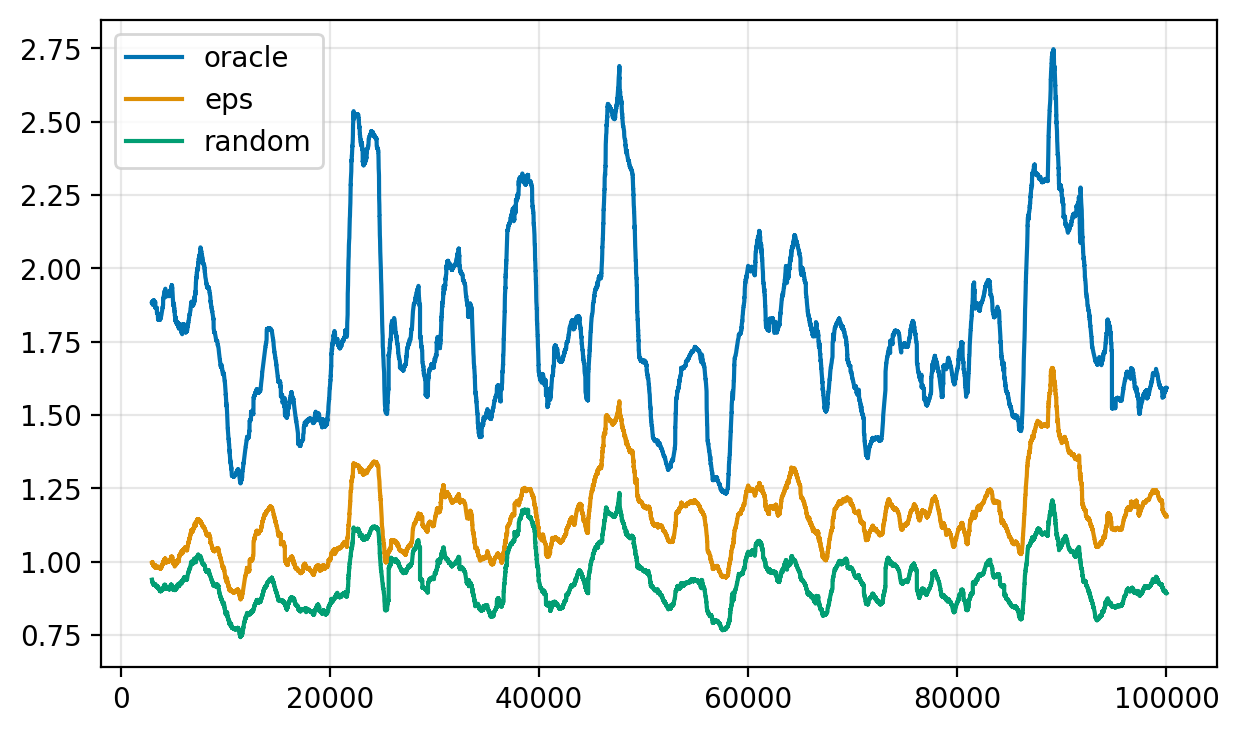

In [55]:
rewards.rolling(window=3_000).mean().plot()
plt.grid(alpha=0.3)

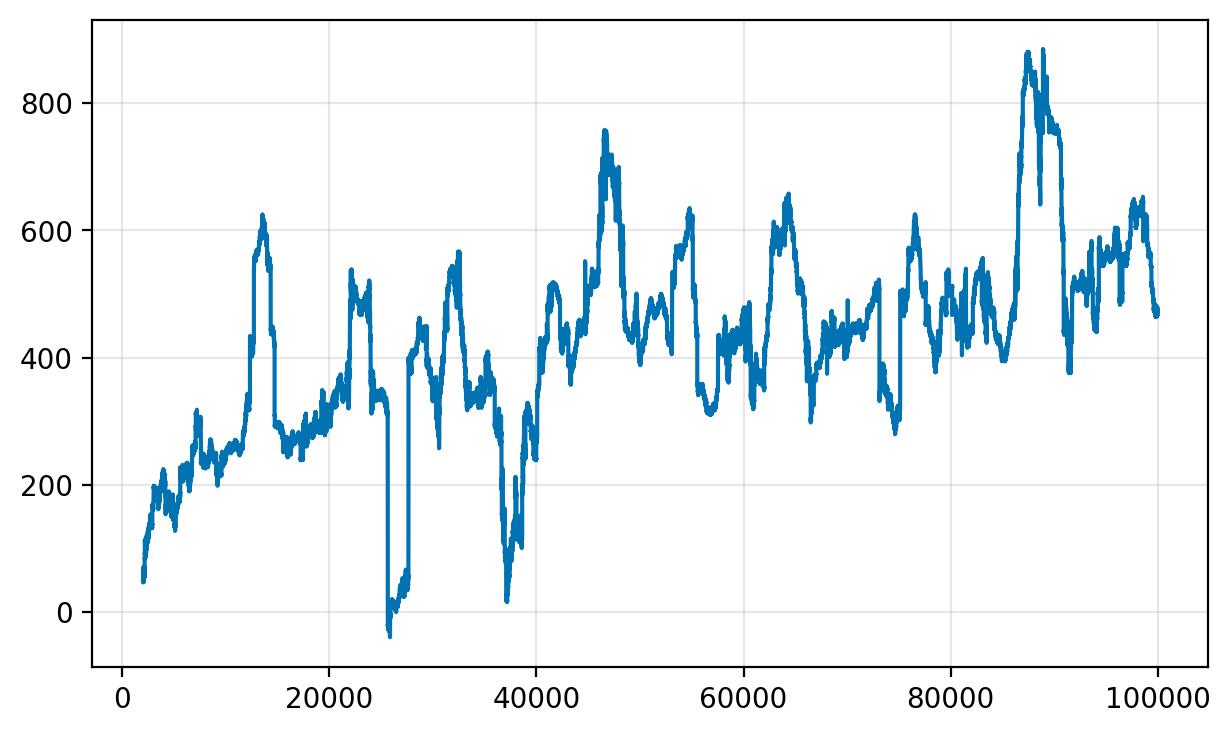

In [56]:
(rewards["eps"] - rewards["random"]).rolling(2_000).sum().plot()
plt.grid(alpha=0.3)

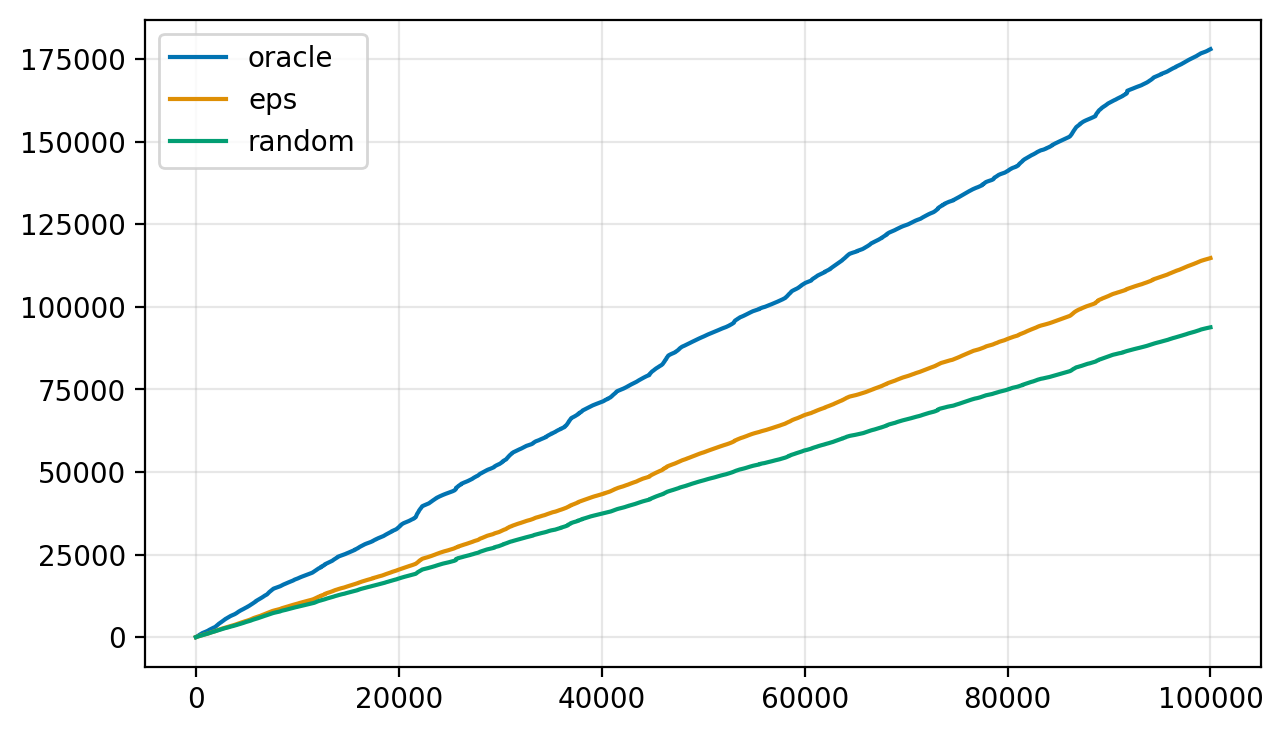

In [58]:
rewards.cumsum().plot()
plt.legend()
plt.grid(alpha=0.3)

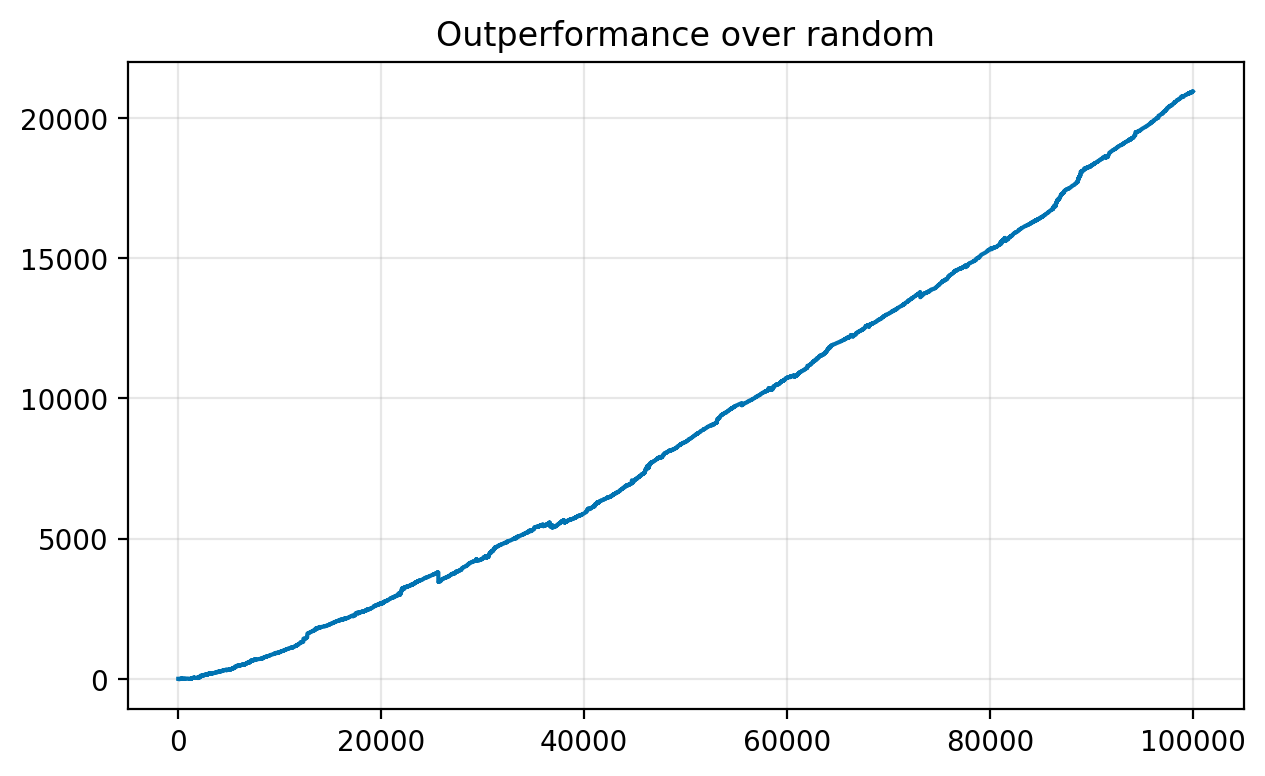

In [59]:
plt.plot((rewards_eps - rewards_random).cumsum())
plt.title("Outperformance over random")
plt.grid(alpha=0.3)

## An $\epsilon$-greedy MLP

In [61]:
# We start by building a bandit problem where we are only given the possible arms to pull and the (latent) rewards
X = df_all[[c for c in df_all if ("video_id" in c) or ("like_cnt" in c)]]
Y = df_all[[c for c in df_all if "watch_ratio" in c]]
X.head()

,video_id_0,like_cnt_0,video_id_1,like_cnt_1,video_id_2,like_cnt_2,video_id_3,like_cnt_3,video_id_4,like_cnt_4
group,,,,,,,,,,
0,0,4726,1.0,129431.0,2.0,92689.0,3.0,191275.0,4.0,26539.0
1,5,3180,6.0,241328.0,7.0,2614.0,8.0,594.0,9.0,2336.0
2,10,1131,11.0,105221.0,12.0,185.0,13.0,22378.0,14.0,489.0
3,15,520,16.0,30362.0,17.0,6913.0,18.0,4029.0,19.0,3104.0
4,20,30347,21.0,160075.0,22.0,2949.0,23.0,2492.0,24.0,42.0


In [65]:
X, Y = jax.tree.map(np.array, (X, Y))
n_obs = len(X)

n_features = 2 # video id and like_cnt
X = X.reshape(-1, n_arms, n_features)

In [66]:
n_videos = len(small_matrix_sub["video_id"].unique())
bandit_map = Bandit(pulls=0, values=0, eps=None, alpha=None)

In [67]:
import flax.linen as nn

In [68]:
class MLP(nn.Module):
    n_videos: int
    n_out: int
    embedding_dim: int
    n_hidden: int

    @nn.compact
    def __call__(self, x):
        x_embedding = nn.Embed(self.n_videos, self.embedding_dim)(x[..., 0].astype(int))
        x_features = nn.Dense(self.n_hidden)(x[..., 1:])
        x = jnp.concat([x_embedding, x_features], axis=-1)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x) # reward
        return x

In [69]:
mlp = MLP(n_videos=n_videos, n_out=5, embedding_dim=20, n_hidden=20)

In [71]:
key = jax.random.PRNGKey(314)

In [72]:
params_init = mlp.init(key, X[0, 0])

In [73]:
jax.vmap(mlp.apply, in_axes=(None, 0))(params_init, X[0])

Array([[ 0.048],
       [32.151],
       [ 0.137],
       [-9.508],
       [ 2.518]], dtype=float32)